In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

from warnings import filterwarnings
filterwarnings("ignore")


from math import ceil
from typing import Any, Dict, List

import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from tqdm import tqdm

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
from src.detector.get_dicts import get_COVID19_data_dicts, get_COVID19_data_dicts_test
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml

from pathlib import Path
import dataclasses

In [2]:
def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        if label == 0:
            label = 'opacity'
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def get_pred(image_id: str, labels: ndarray, boxes: ndarray, scores: ndarray) -> list:
    preds = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        res_dict = {
            'image_id': image_id,
            'x_min': xmin,
            'y_min': ymin,
            'x_max': xmax,
            'y_max': ymax,
            'score': score,
            'label': label
        }
        preds.append(res_dict)
    return preds


def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

In [3]:
# --- configs ---
thing_classes = [
#     "none",
    "opacity"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}

In [4]:
category_name_to_id

{'opacity': 0}

In [5]:
flags_dict = {
    "debug": False,
    "fold": 4,
    "outdir": "inference_results/", 
#     "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "root_imgdir": "/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/test/",
    "path_to_meta_df": "../../cross_validation_scheme/detectron_prepared_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/detectron_prepared_data/detectron_prepared_df.csv",
    "use_cache": False,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 10000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupMultiStepLR",
    "base_lr": 0.00025,
    "num_workers": 4,
    "ims_per_batch": 4,
    
#     "aug_kwargs": {
#         "HorizontalFlip": {"p": 0.5},
#         "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
#         "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.7},
#         "RandomBrightnessContrast": {"p": 0.5},
#         "CLAHE": {"clip_limit": (1,4), "p": 0.5},
#         "GaussianBlur": {"p": 0.2}
#     },
}

In [6]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [7]:
import pandas as pd
meta_df = pd.read_csv("../../../../../../hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/meta.csv")
meta_df = meta_df[meta_df['split']=='test']
meta_df.rename(columns={'dim0':'height', 'dim1':'width'}, inplace=True)
meta_df = meta_df[['image_id', 'height', 'width']]
meta_df.reset_index(inplace=True, drop=True)
meta_df

,image_id,height,width
0,a29c5a68b07b,2320,2828
1,9850b5470fd6,2330,2382
2,8d6dea06a032,2422,3344
3,dfc5c09a50bc,1140,1387
4,7230234e120a,2318,2383
...,...,...,...
1258,a43200bd5ceb,2336,2836
1259,37bf83df1b86,3480,4240
1260,b30d2aef985f,3480,4240
1261,a37a362df0ac,3480,4240


In [8]:
root_inputdir = Path("../../../../../../hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/test/")

debug = flags.debug

outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)

In [9]:
cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
cfg.MODEL.WEIGHTS = str("results/F4_RetinaNet_4000_jpg.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> inference_results


In [10]:
meta_df

,image_id,height,width
0,a29c5a68b07b,2320,2828
1,9850b5470fd6,2330,2382
2,8d6dea06a032,2422,3344
3,dfc5c09a50bc,1140,1387
4,7230234e120a,2318,2383
...,...,...,...
1258,a43200bd5ceb,2336,2836
1259,37bf83df1b86,3480,4240
1260,b30d2aef985f,3480,4240
1261,a37a362df0ac,3480,4240


In [11]:
DatasetCatalog.register(
    "COVID19_data_test", lambda: get_COVID19_data_dicts_test(
        root_imgdir=flags.root_imgdir,
        test_meta=meta_df,
        use_cache=False,
        debug=debug
    )
)
MetadataCatalog.get("COVID19_data_test").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("COVID19_data_test")
dataset_dicts = get_COVID19_data_dicts_test(
                                                root_imgdir=flags.root_imgdir,
                                                test_meta=meta_df,
                                                use_cache=False,
                                                debug=debug
)

100%|██████████| 1263/1263 [00:00<00:00, 20156.48it/s]

Creating data...


In [12]:
results_list = []
index = 0
batch_size = 4

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
#             out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # cv2_imshow(out.get_image()[:, :, ::-1])
#             cv2.imwrite(str(outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])

        image_id, dim0, dim1 = meta_df.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 1 0 0 1 1x.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

#             h_ratio = dim0 / resized_height
#             w_ratio = dim1 / resized_width
            h_ratio = 1
            w_ratio = 1
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = get_pred(image_id, pred_classes_array, pred_boxes_array, pred_scores_array)
        results_list.append(result)
        index += 1
final_list = [item for sublist in results_list for item in sublist]
result_df = pd.DataFrame(final_list)

100%|██████████| 316/316 [01:06<00:00,  4.72it/s]


In [13]:
result_df

,image_id,x_min,y_min,x_max,y_max,score,label
0,a29c5a68b07b,247,271,537,822,0.668310,0
1,a29c5a68b07b,682,273,976,818,0.647968,0
2,a29c5a68b07b,266,394,453,730,0.252349,0
3,a29c5a68b07b,738,364,931,639,0.238518,0
4,a29c5a68b07b,782,379,969,743,0.140831,0
...,...,...,...,...,...,...,...
75491,a0f473f71878,926,105,1024,377,0.053210,0
75492,a0f473f71878,731,9,836,152,0.053198,0
75493,a0f473f71878,643,188,980,733,0.052667,0
75494,a0f473f71878,463,102,608,357,0.052476,0


In [14]:
from ensemble_boxes import *
from collections import Counter

In [15]:
result_df.image_id.unique()

array(['a29c5a68b07b', '9850b5470fd6', '8d6dea06a032', ...,
       'b30d2aef985f', 'a37a362df0ac', 'a0f473f71878'], dtype=object)

In [16]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color, score):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()
    
    score = str(score)
    label = label + ' ' + score

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

In [17]:
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]
thickness = 3
viz_labels = ['Opacity']

0it [00:00, ?it/s]

Bboxes before nmv:
 [[247, 271, 537, 822], [682, 273, 976, 818], [266, 394, 453, 730], [738, 364, 931, 639], [782, 379, 969, 743], [312, 447, 508, 777], [529, 173, 953, 854], [176, 106, 621, 834], [672, 232, 908, 640], [164, 343, 473, 885], [266, 413, 406, 629], [299, 350, 502, 649], [230, 495, 482, 835], [358, 281, 532, 528], [794, 412, 919, 619], [631, 128, 1024, 976], [770, 365, 902, 564], [850, 408, 1009, 821], [288, 160, 570, 622], [243, 234, 427, 685], [793, 297, 961, 618], [387, 329, 548, 604], [369, 510, 540, 811], [379, 348, 489, 501], [707, 340, 873, 586], [691, 483, 975, 761], [293, 250, 493, 550], [744, 177, 1004, 663], [207, 385, 399, 776], [206, 584, 553, 885], [723, 587, 941, 846]]
Labels before nmv:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Counter({0: 31})


1it [00:00,  3.19it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bboxes after nmv:
 [[247.0, 271.0, 537.0, 822.0], [682.0, 273.0, 976.0, 818.0], [266.0, 394.0, 453.0, 730.0], [738.0, 364.0, 931.0, 639.0], [782.0, 379.0, 969.0, 743.0], [312.0, 447.0, 508.0, 777.0], [529.0, 173.0, 953.0, 854.0], [176.0, 106.0, 621.0, 834.0], [672.0, 232.0, 908.0, 640.0], [164.0, 343.0, 473.0, 885.0], [266.0, 413.0, 406.0, 629.0], [299.0, 350.0, 502.0, 649.0], [230.0, 495.0, 482.0, 835.0], [358.0, 281.0, 532.0, 528.0], [794.0, 412.0, 919.0, 619.0], [631.0, 128.0, 1024.0, 976.0], [770.0, 365.0, 902.0, 564.0], [850.0, 408.0, 1009.0, 821.0], [288.0, 160.0, 570.0, 622.0], [243.0, 234.0, 427.0, 685.0], [793.0, 297.0, 961.0, 618.0], [387.0, 329.0, 548.0, 604.0], [369.0, 510.0, 540.0, 811.0], [379.0, 348.0, 489.0, 501.0], [707.0, 340.0, 873.0, 586.0], [691.0, 483.0, 975.0, 761.0], [293.0, 250.0, 493.0, 550.0], [744.0, 177.0, 1004.0, 663.0], [207.0, 385.0, 399.0, 776.0], [206.0, 584.0

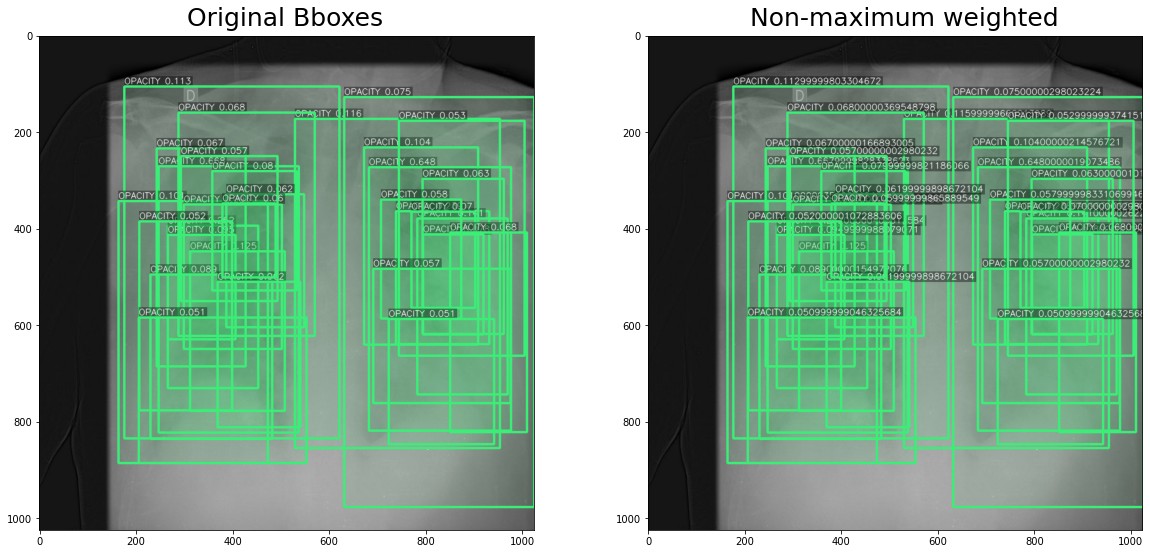

In [20]:
iou_thr = 0.55
skip_box_thr = 0.0000
sigma = 0.1
viz_images = []

for i, img_id in tqdm(enumerate(['a29c5a68b07b'])):
    path = f'/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/test/{img_id}.jpg'
    img_array  = cv2.imread(path)
#     image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = result_df[result_df.image_id==img_id]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['label'].to_numpy().tolist()
    scores_viz = img_annotations['score'].to_numpy().tolist()
    
    print("Bboxes before nmv:\n", boxes_viz)
    print("Labels before nmv:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label, score_tmp in zip(boxes_viz, labels_viz, scores_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        score_tmp = round(score_tmp, 3)
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color, score_tmp)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['label'].unique().tolist()
    count_dict = Counter(img_annotations['label'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.label==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list = img_annotations[img_annotations.label==cid]['label'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.label==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores = img_annotations[img_annotations.label==cid]['score'].tolist()
#             scores_list.append(np.ones(len(cls_list)).tolist())
            scores_list.append(scores)

            weights.append(1)
            
            
#     print("boxes_list = ", boxes_list)
#     print("scores_list = ", scores_list)
#     print("labels_list = ", labels_list)
            
# #     Perform NMS
#     boxes, scores, box_labels = nms(boxes_list, scores_list, labels_list, weights=None,
#                                     iou_thr=iou_thr)

    boxes, scores, box_labels= non_maximum_weighted(boxes_list, scores_list, labels_list, weights=None,
                                                         iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#     print("boxes = ", boxes)

#     print(scores)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    box_scores = scores.round(3).tolist()
    
    print(box_labels)

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after nmv:\n", boxes)
    print("Labels after nmv:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label, score_tmp in zip(boxes, box_labels, box_scores):
        print(score_tmp)
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color, score_tmp)
    viz_images.append(img_after)
#     print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-maximum weighted", va="top", ha="center", size=25)
plt.savefig(outdir/'nms.png', bbox_inches='tight')
plt.show()